# Kaggle competition for DMA Fall 22


### ADD DESCRIPTION

In [ ]:
#!pip install cpi
#import cpi
#cpi.update()
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Will probably ned more sklearn packages
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from statsmodels.graphics.api import abline_plot
import statsmodels.api as sm
from statsmodels.genmod import families

from scipy import stats

# Import Dataset
Download dataset at this link: https://www.kaggle.com/competitions/dma2022-competition/data

In [ ]:
import os
os.getcwd()

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)
root = "/content/drive/MyDrive/DMA Fall22"

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/DMA Fall22/train.csv")  # Change path if change file or folder name
test_df = pd.read_csv("/content/drive/MyDrive/DMA Fall22/test.csv") # Change path if change file or folder name

In [ ]:
print(len(train_df), len(test_df))

891 418


Prepare data and test accuracy

---



In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Prepare Data

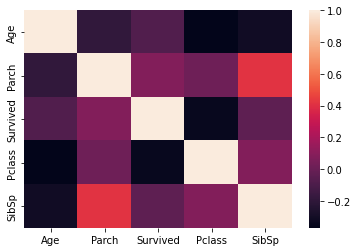

In [ ]:
train_r = train_df[['Age', 'Parch', 'Survived', 'Pclass', 'Embarked', 'SibSp']].copy()
correlation = train_r.corr()
sns.heatmap(correlation)

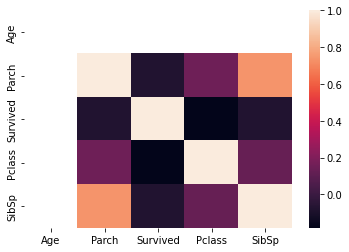

In [ ]:
train_r_no_age = train_r[train_r['Age'].isna()]
train_r_no_age
corr2 = train_r_no_age.corr()
sns.heatmap(corr2)

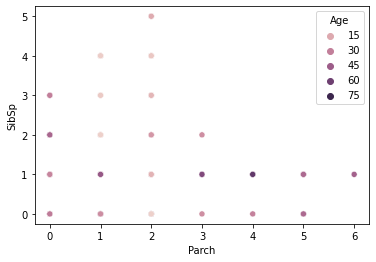

In [ ]:
x = train_r_no_age['Parch']
y = train_r_no_age['SibSp']
sns.scatterplot(data = train_r, x = 'Parch', y = 'SibSp', hue = 'Age')


In [ ]:
data_r = train_df[['Survived', 'Sex', 'Pclass', 'Age', 'Parch']].copy()
data_r

,Survived,Sex,Pclass,Age,Parch
0,0,male,3,22.0,0
1,1,female,1,38.0,0
2,1,female,3,26.0,0
3,1,female,1,35.0,0
4,0,male,3,35.0,0
...,...,...,...,...,...
886,0,male,2,27.0,0
887,1,female,1,19.0,0
888,0,female,3,NaN,2
889,1,male,1,26.0,0


In [ ]:
# Isolate columns of interest
data = train_df[["Survived", "Pclass", "Sex", "Embarked", "Age", "SibSp", "Parch"]].copy()

# Binning for age



# One-hot encode passenger class and gender
Pclass = pd.get_dummies(data.Pclass, prefix="class")
Pclass.index = data.index
Embarked = pd.get_dummies(data.Embarked, prefix="port")
Embarked.index = data.index
Sex = pd.Series([1 if x == "male" else 0 for x in data.Sex], index = data.index).rename("Sex")

# Combine columns to form data
done_dusted_data = pd.concat([data.Survived, Pclass.iloc[:, 1:], Embarked.iloc[:, 1:], Sex], axis=1)

# Test/train split (parameters are X, y)
X_train, X_test, y_train, y_test = train_test_split(done_dusted_data.iloc[:, 1:], done_dusted_data.iloc[:, 0], test_size=0.33, random_state=42)

# Sanity check
print("len(X_train) == len(y_train):", len(X_train) == len(y_train))
print("len(X_test) == len(y_test): ", len(X_test) == len(y_test))

print("Predicting on", [feature for feature in X_train.columns])

len(X_train) == len(y_train): True
len(X_test) == len(y_test):  True
Predicting on ['class_2', 'class_3', 'port_Q', 'port_S', 'Sex']


Four Models 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

X_train_rm_Pclass = X_train.drop(['class_2', 'class_3'], axis=1)
X_test_rm_Pclass = X_test.drop(['class_2', 'class_3'], axis=1)

# Logistic regression 
LR = LogisticRegression(random_state=1, solver='lbfgs', multi_class='ovr').fit(X_train_rm_Pclass, y_train)
y_hat_lr = LR.predict(X_test_rm_Pclass)
print("LR Accuracy:",str(round(accuracy_score(y_test,y_hat_lr), 4) * 100) + "%")

# Neural network -- Improves with Pclass
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1).fit(X_train, y_train)
y_hat_nn = clf.predict(X_test)
print("NN Accuracy:",str(round(accuracy_score(y_test,y_hat_nn), 4) * 100) + "%")

# Random forest -- Improves with Pclass
RF = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=1).fit(X_train, y_train)
y_hat_rf = RF.predict(X_test)
print("RF Accuracy:",str(round(accuracy_score(y_test,y_hat_rf), 4) * 100) + "%")

# Support vector machine
SVM = svm.LinearSVC().fit(X_train, y_train)
y_hat_svm = SVM.predict(X_test)
print("SVM Accuracy:",str(round(accuracy_score(y_test,y_hat_svm), 4) * 100) + "%")

LR Accuracy: 79.66%
NN Accuracy: 80.0%
RF Accuracy: 80.0%
SVM Accuracy: 79.66%


Predict for new data

In [ ]:
# Isolate columns of interest
data = test_df[["Pclass", "Sex", "Embarked"]].copy()

# One-hot encode passenger class and gender
Pclass = pd.get_dummies(data.Pclass, drop_first=True, prefix="class")
Pclass.index = data.index
Embarked = pd.get_dummies(data.Embarked, drop_first=True,  prefix="port")
Embarked.index = data.index
Sex = pd.Series([1 if x == "male" else 0 for x in data.Sex], index = data.index).rename("Sex")

# Combine columns to form data
X = pd.concat([Pclass, Embarked, Sex], axis=1)
predictions_NN = clf.predict(X)

In [ ]:
# results = pd.DataFrame(data={"PassengerId":test_df.PassengerId, "Survived":predictions})
# results.to_csv("/content/drive/MyDrive/DMA Fall22/lab5a_predictions.csv", index=False)

Need to predict mortality for every passenger, including those with missing age value. If we want to use age as a parameter, we've got to fill the NaN age values (as opposed to dropping as we did above). Could use age average or try to predict age. Alternatively, you could exclude the feature or only use for rows where it is present.

In [ ]:
# Predict if eles using linear regression 
from sklearn.linear_model import LinearRegression

data = train_df[["Age","SibSp", "Parch"]].dropna(axis=0)
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.Age, test_size=0.33, random_state=42)
model = LinearRegression().fit(X_train, y_train)
age_prediction = model.predict(X_test)
is_child_pred = [age <= 16 for age in age_prediction]
is_child = [age <= 16 for age in y_test]

print("Accuracy:",str(round(accuracy_score(is_child, is_child_pred), 4) * 100) + "%")

Accuracy: 82.63000000000001%


In [ ]:
submitted_df = pd.read_csv("/content/drive/MyDrive/DMA Fall22/lab5a_predictions_NN.csv")
old_predictions = submitted_df["Survived"]
new_predictions = predictions_NN
print("Count non-matching rows:", len(new_predictions) - np.count_nonzero(old_predictions == new_predictions))

Count non-matching rows: 0


In [ ]:
len(new_predictions) - np.count_nonzero(old_predictions == new_predictions)


0